# Model1 - RNN model of CPRO task using PyTorch

#### Taku Ito
#### 09/30/2018

In [8]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import sys
sys.path.append('../utils/bctpy/')
import bct
import time

retrain = True
modeldir = '../../..//models/Model3c/'

## Define network inputs (sensory inputs + task rules)

In [2]:
def createSensoryInputs(nStims=2):
    stimdata = {}
    # Stim 1 empty columns
    stimdata['Color1'] = []
    stimdata['Orientation1'] = []
    stimdata['Pitch1'] = []
    stimdata['Constant1'] = []
    # Stim 2 empty columns
    stimdata['Color2'] = []
    stimdata['Orientation2'] = []
    stimdata['Pitch2'] = []
    stimdata['Constant2'] = []
    # Code for RNN training
    stimdata['Code'] = []

    # Property index tells us which columns ID the property in question
    color = {0:'red',
             1:'blue'}
    orientation = {2:'vertical',
                   3:'horizontal'}
    pitch = {4:'high',
             5:'low'}
    constant = {6:'constant',
                7:'beeping'}
    
    for col1 in color:
        for col2 in color:
            for ori1 in orientation:
                for ori2 in orientation:
                    for pit1 in pitch:
                        for pit2 in pitch:
                            for con1 in constant:
                                for con2 in constant:
                                    code = np.zeros((8*nStims,))
                                    # Stim 1
                                    code[col1] = 1
                                    stimdata['Color1'].append(color[col1])
                                    code[ori1] = 1
                                    stimdata['Orientation1'].append(orientation[ori1])
                                    code[pit1] = 1
                                    stimdata['Pitch1'].append(pitch[pit1])
                                    code[con1] = 1
                                    stimdata['Constant1'].append(constant[con1])
                                    # Stim 2 -- need to add 8, since this is the second stimuli
                                    code[col2+8] = 1
                                    stimdata['Color2'].append(color[col2])
                                    code[ori2+8] = 1
                                    stimdata['Orientation2'].append(orientation[ori2])
                                    code[pit2+8] = 1
                                    stimdata['Pitch2'].append(pitch[pit2])
                                    code[con2+8] = 1
                                    stimdata['Constant2'].append(constant[con2])
                                    
                                    # Code
                                    stimdata['Code'].append(code)
                    
    return pd.DataFrame(stimdata) 

def createRulePermutations():
    # May need to change this - both and not both are negations of each other, as are either and neither
    logicRules = {0: 'both',
                  1: 'notboth',
                  2: 'either',
                  3: 'neither'}
    sensoryRules = {4: 'red',
                    5: 'vertical',
                    6: 'high',
                    7: 'constant'}
    motorRules = {8: 'l_mid',
                  9: 'l_ind',
                  10: 'r_ind',
                  11: 'r_mid'}
    
    
    taskrules = {}
    taskrules['Logic'] = []
    taskrules['Sensory'] = []
    taskrules['Motor'] = []
    # Create another field for the sensory category (to select stimuli from)
    taskrules['SensoryCategory'] = []
    # For RNN training
    taskrules['Code'] = []
    
    for lo in logicRules:
        for se in sensoryRules:
            for mo in motorRules:
                code = np.zeros((12,))
                # Logic rule
                taskrules['Logic'].append(logicRules[lo])
                code[lo] = 1
                
                # Sensory rule
                taskrules['Sensory'].append(sensoryRules[se])
                code[se] = 1
                # Define sensory category
                if sensoryRules[se]=='red': category = 'Color'
                if sensoryRules[se]=='vertical': category = 'Orientation'
                if sensoryRules[se]=='high': category = 'Pitch'
                if sensoryRules[se]=='constant': category = 'Constant'
                taskrules['SensoryCategory'].append(category)
                
                # Motor rule
                taskrules['Motor'].append(motorRules[mo])
                code[mo] = 1
                
                taskrules['Code'].append(code)
                
    return pd.DataFrame(taskrules)

def createTrainTestTaskRules(taskRuleSet,nTrainSet=32,nTestSet=32):
    """
    Ensure that when we split the task rules, that each set has equal proportions of each task rule
    For example, if there are 32 training tasks, then we should have 8 examples of each rule
    """
    nRulesPerTrainSet = nTrainSet/4.0
    nRulesPerTestSet = nTestSet/4.0
    if nRulesPerTrainSet%4.0!=0:
        raise Exception('ERROR: Number of rules per train/test set needs to be divisible by 4!')
    
    df_test = pd.DataFrame()
    df_train = pd.DataFrame()
    # Make sure all columns exist 
    df_train = df_train.append(taskRuleSet.iloc[0])
    
    # Iterate through tasks in a random manner
    ind = np.arange(len(taskRuleSet))
    np.random.shuffle(ind)
    for i in ind:
        # Identify the rules in this task set
        logic = taskRuleSet.Logic[i]
        sensory = taskRuleSet.Sensory[i]
        motor = taskRuleSet.Motor[i]
        
        # Count number of logic rules for this task set
        nLogic = np.sum(df_train.Logic==logic)
        nSensory = np.sum(df_train.Sensory==sensory)
        nMotor = np.sum(df_train.Motor==motor)
        if nLogic<nRulesPerTrainSet and nSensory<nRulesPerTrainSet and nMotor<nRulesPerTrainSet:
            df_train = df_train.append(taskRuleSet.iloc[i])
        else:
            df_test = df_test.append(taskRuleSet.iloc[i])
                
    return df_train, df_test



## Calculate motor outputs for each set of inputs

In [3]:
motorCode = {0:'l_mid',
             1:'l_ind',
             2:'r_ind',
             3:'r_mid'}

def solveInputs(task_rules, stimuli, printTask=False):
    """
    Solves CPRO task given a set of inputs and a task rule
    """
    logicRule = task_rules.Logic
    sensoryRule = task_rules.Sensory
    motorRule = task_rules.Motor
    
    sensoryCategory = task_rules.SensoryCategory
   
    # Isolate the property for each stimulus relevant to the sensory rule
    stim1 = stimuli[sensoryCategory + '1']
    stim2 = stimuli[sensoryCategory + '2']
    
    # Run through logic rule gates
    if logicRule == 'both':
        if stim1==sensoryRule and stim2==sensoryRule:
            gate = True
        else:
            gate = False
            
    if logicRule == 'notboth':
        if stim1!=sensoryRule or stim2!=sensoryRule:
            gate = True
        else:
            gate = False
    
    if logicRule == 'either':
        if stim1==sensoryRule or stim2==sensoryRule:
            gate = True
        else:
            gate = False
            
    if logicRule == 'neither':
        if stim1!=sensoryRule and stim2!=sensoryRule:
            gate = True
        else:
            gate = False
            
    
    ## Print task first
    if printTask:
        print 'Logic rule:', logicRule
        print 'Sensory rule:', sensoryRule
        print 'Motor rule:', motorRule
        print '**Stimuli**'
        print stim1, stim2
    
    # Apply logic gating to motor rules
    if motorRule=='l_mid':
        if gate==True:
            motorOutput = 'l_mid'
        else:
            motorOutput = 'l_ind'
        
    if motorRule=='l_ind':
        if gate==True:
            motorOutput = 'l_ind'
        else:
            motorOutput = 'l_mid'
        
    if motorRule=='r_mid':
        if gate==True:
            motorOutput = 'r_mid'
        else:
            motorOutput = 'r_ind'
        
    if motorRule=='r_ind':
        if gate==True:
            motorOutput = 'r_ind'
        else:
            motorOutput = 'r_mid'
        
    outputcode = np.zeros((4,))
    if motorOutput=='l_mid': outputcode[0] = 1
    if motorOutput=='l_ind': outputcode[1] = 1
    if motorOutput=='r_ind': outputcode[2] = 1
    if motorOutput=='r_mid': outputcode[3] = 1
        
    return motorOutput, outputcode
    

In [4]:
def createTrainingSet(taskRuleSet,nStimuli=100,nTasks=64,delay=False,shuffle=True):
    """
    Randomly generates a set of stimuli (nStimuli) for each task rule
    Will end up with 64 (task rules) * nStimuli total number of input stimuli
    
    If shuffle keyword is True, will randomly shuffle the training set
    Otherwise will start with taskrule1 (nStimuli), taskrule2 (nStimuli), etc.
    """
    
    stimuliSet = createSensoryInputs()

    networkIO_DataFrame = {}
    networkIO_DataFrame['LogicRule'] = []
    networkIO_DataFrame['SensoryRule'] = []
    networkIO_DataFrame['MotorRule'] = []
    networkIO_DataFrame['Color1'] = []
    networkIO_DataFrame['Color2'] = []
    networkIO_DataFrame['Orientation1'] = []
    networkIO_DataFrame['Orientation2'] = []
    networkIO_DataFrame['Pitch1'] = []
    networkIO_DataFrame['Pitch2'] = []
    networkIO_DataFrame['Constant1'] = []
    networkIO_DataFrame['Constant2'] = []
    networkIO_DataFrame['MotorResponse'] = []

    # Create 1d array to randomly sample indices from
    stimIndices = np.arange(len(stimuliSet))
    taskIndices = np.arange(len(taskRuleSet))
    
    randomTaskIndices = np.random.choice(taskIndices,nTasks,replace=False)
    taskRuleSet2 = taskRuleSet.iloc[randomTaskIndices].copy(deep=True)
    taskRuleSet2 = taskRuleSet2.reset_index(drop=True)
    taskRuleSet = taskRuleSet2.copy(deep=True)

    networkInputCode = []
    networkOutputCode = []
    for taskrule in taskRuleSet.index:
        
        randomStimuliIndices = np.random.choice(stimIndices,nStimuli,replace=False)
        stimuliSet2 = stimuliSet.iloc[randomStimuliIndices].copy(deep=True)
        stimuliSet2 = stimuliSet2.reset_index(drop=True)
        
        for stim in stimuliSet2.index:

            networkInputCode.append(np.hstack((taskRuleSet.Code[taskrule], stimuliSet2.Code[stim])))
            tmpresp, tmpcode = solveInputs(taskRuleSet.iloc[taskrule], stimuliSet2.iloc[stim])
            networkOutputCode.append(tmpcode)

            # Task rule info
            networkIO_DataFrame['LogicRule'].append(taskRuleSet.Logic[taskrule])
            networkIO_DataFrame['SensoryRule'].append(taskRuleSet.Sensory[taskrule])
            networkIO_DataFrame['MotorRule'].append(taskRuleSet.Motor[taskrule])
            # Stimuli info['
            networkIO_DataFrame['Color1'].append(stimuliSet2.Color1[stim])
            networkIO_DataFrame['Color2'].append(stimuliSet2.Color2[stim])
            networkIO_DataFrame['Orientation1'].append(stimuliSet2.Orientation1[stim])
            networkIO_DataFrame['Orientation2'].append(stimuliSet2.Orientation2[stim])
            networkIO_DataFrame['Pitch1'].append(stimuliSet2.Pitch1[stim])
            networkIO_DataFrame['Pitch2'].append(stimuliSet2.Pitch2[stim])
            networkIO_DataFrame['Constant1'].append(stimuliSet2.Constant1[stim])
            networkIO_DataFrame['Constant2'].append(stimuliSet2.Constant2[stim])
            # Motor info
            networkIO_DataFrame['MotorResponse'].append(tmpresp)
            

    tmpdf = pd.DataFrame(networkIO_DataFrame)
    
    if shuffle:
        ind = np.arange(len(tmpdf),dtype=int)
        np.random.shuffle(ind)
        networkIO_DataFrame = tmpdf.iloc[ind]
        networkInputCode = np.asarray(networkInputCode)[ind]
        networkOutputCode = np.asarray(networkOutputCode)[ind]

    # Add delay (i.e., 0 inputs & 0 outputs just incase)
    if delay:
        networkInputCode2 = []
        networkOutputCode2 = []
        nDelays = 1
        
        for index in range(len(networkIO_DataFrame)):
            networkInputCode2.append(networkInputCode[index])
            networkOutputCode2.append(networkOutputCode[index])
            
            for delay in range(nDelays):
                networkInputCode2.append(np.zeros((len(networkInputCode[index]),)))
                networkOutputCode2.append(np.zeros((len(networkOutputCode[index]),)))
            
            
        networkInputCode = networkInputCode2
        networkOutputCode = networkOutputCode2
            
        
        
    return networkIO_DataFrame, networkInputCode, networkOutputCode
        


# Train RNN first on a subset of tasks (half the tasks)

In [6]:
# Train 
nTrainSet = 32
nTestSet = 32
taskRuleSet = createRulePermutations()
if retrain:
    trainRuleSet, testRuleSet = createTrainTestTaskRules(taskRuleSet,nTrainSet=nTrainSet,nTestSet=nTestSet)
#     trainRuleSet.to_hdf(modeldir + 'trainRuleSet.h5','trainRuleSet')
#     testRuleSet.to_hdf(modeldir + 'testRuleSet.h5','testRuleSet')
else:
    trainRuleSet = pd.read_hdf(modeldir + 'trainRuleSet.h5','trainRuleSet')
    testRuleSet = pd.read_hdf(modeldir + 'testRuleSet.h5','testRuleSet')
    
stimuliSet = createSensoryInputs()

In [83]:
NUM_RULE_INPUTS = len(taskRuleSet.Code[0])
NUM_SENSORY_INPUTS = len(stimuliSet.Code[0])
NUM_HIDDEN = 128
NUM_MOTOR_DECISION_OUTPUTS = 4
# NUM_TRAINING_ITERATIONS = 100000 # Maybe 20000 is better
NUM_TRAINING_ITERATIONS = 10000 # Maybe 20000 is better
NUM_TRAINING_RULES_PER_EPOCH = 4
NUM_TRAINING_STIMULI_PER_RULE = 5
NUM_TRAINING_STIMULI_PER_RULE = 200

# bias = Variable(torch.Tensor(1, NUM_HIDDEN).uniform_(-1, 0), requires_grad=True)
bias = Variable(torch.cuda.FloatTensor(1, NUM_HIDDEN).uniform_(-1, 0), requires_grad=True)
drdt = 0.05

if retrain:

    starttime = time.time()
    
#     w_in = Variable(torch.Tensor(NUM_RULE_INPUTS + NUM_SENSORY_INPUTS, NUM_HIDDEN).uniform_(-0.5,0.5), requires_grad=True)
#     w_rec = Variable(torch.Tensor(NUM_HIDDEN, NUM_HIDDEN).uniform_(-0.5,0.5), requires_grad=True)
#     w_out = Variable(torch.Tensor(NUM_HIDDEN, NUM_MOTOR_DECISION_OUTPUTS).uniform_(-0.5,0.5), requires_grad=True)

    w_in = Variable(torch.cuda.FloatTensor(NUM_RULE_INPUTS + NUM_SENSORY_INPUTS, NUM_HIDDEN).uniform_(-0.5,0.5), requires_grad=True)
    w_rec = Variable(torch.cuda.FloatTensor(NUM_HIDDEN, NUM_HIDDEN).uniform_(-0.5,0.5), requires_grad=True)
    w_out = Variable(torch.cuda.FloatTensor(NUM_HIDDEN, NUM_MOTOR_DECISION_OUTPUTS).uniform_(-0.5,0.5), requires_grad=True)

    #outputs = networkOutputCode
    #randomInputs = np.random.randint(0,len(networkInputCode),10)
    #inputs = np.asarray(networkInputCode)[randomInputs]

    accuracyPerEpoch = []

    learning_rate = 0.01
    for iteration_num in range(NUM_TRAINING_ITERATIONS):
#         previous_r = Variable(torch.Tensor(1, NUM_HIDDEN).zero_(), requires_grad=False)
        previous_r = Variable(torch.cuda.FloatTensor(1, NUM_HIDDEN).zero_(), requires_grad=False)
        error = 0

        # Increase number of presented tasks with number of increased iterations
        # Don't allow more than 10 task rules per epoch, since it will just slow training down
        if iteration_num % 2000 == 0:
            if NUM_TRAINING_RULES_PER_EPOCH < 10:
                NUM_TRAINING_RULES_PER_EPOCH += 1

        df, inputs, outputs = createTrainingSet(trainRuleSet, nStimuli=NUM_TRAINING_STIMULI_PER_RULE, nTasks=NUM_TRAINING_RULES_PER_EPOCH, delay=False) # 64 * 20 stimuli

        acc = []
#         for timestep in range(len(inputs)):
#             target = Variable(torch.Tensor([outputs[timestep]]))
#         u = Variable(torch.Tensor(inputs))
#         target = Variable(torch.Tensor(outputs))
        u = Variable(torch.cuda.FloatTensor(inputs))
        target = Variable(torch.cuda.FloatTensor(outputs))

        # The neural network
        r = previous_r - drdt*previous_r + drdt* F.relu(previous_r.mm(w_rec) + u.mm(w_in) + bias)
        output = r.mm(w_out)

        error += torch.mean((output - target).pow(2))  # Mean squared error loss
        previous_r = r  # Recurrence

   #     if iteration_num % 1000 == 0:
   #         print(output.data.numpy())

        tmp_target = target.cpu()
        if np.sum(np.asarray(tmp_target.data))!=0:
            tmp_output = output.cpu()
            for trial in range(tmp_output.data.shape[0]):
                distance = np.abs(1.0-tmp_output.data[trial])
                if np.where(distance == distance.min())[0][0] == np.where(np.asarray(tmp_target.data[trial]))[0][0]:
                    acc.append(1.0)
                else:
                    acc.append(0.0)

        if iteration_num % 1000 == 0:
            print 'Iteration:', iteration_num
            print '\tloss:', error.data
            print '\tAccuracy: ' + str(round(np.mean(acc)*100.0,4)) +'%'

        accuracyPerEpoch.append(np.mean(acc)*100.0)
        if iteration_num>10:
            if np.sum(np.asarray(accuracyPerEpoch[-10:])>96.0)==10:
                print 'Last 10 epochs had above 96% accuracy... stopping training'
                break


        # Learning
        error.backward()
        w_in.data -= learning_rate*w_in.grad.data; w_in.grad.data.zero_()
        w_rec.data -= learning_rate*w_rec.grad.data; w_rec.grad.data.zero_()
        w_out.data -= learning_rate*w_out.grad.data; w_out.grad.data.zero_()
        bias.data -= learning_rate*bias.grad.data; bias.grad.data.zero_()

    torch.save(w_in,modeldir + 'Model3c_Win')
    torch.save(w_rec,modeldir + 'Model3c_Wrec')
    torch.save(w_out,modeldir + 'Model3c_Wout')
    torch.save(bias,modeldir + 'Model3c_Bias')

    endtime = time.time()
    
    print 'Time elapsed:', endtime - starttime
    
else:
    
    w_in = torch.load(modeldir + 'Model3c_Win')
    w_rec = torch.load(modeldir + 'Model3c_Wrec')
    w_out = torch.load(modeldir + 'Model3c_Wout')
    bias = torch.load(modeldir + 'Model3c_Bias')


Iteration: 0
	loss: tensor(0.2471, device='cuda:0')
	Accuracy: 25.1%
Iteration: 1000
	loss: tensor(0.2173, device='cuda:0')
	Accuracy: 24.5%
Iteration: 2000
	loss: tensor(0.2041, device='cuda:0')
	Accuracy: 21.5833%
Iteration: 3000
	loss: tensor(0.1870, device='cuda:0')
	Accuracy: 36.1667%
Iteration: 4000
	loss: tensor(0.1799, device='cuda:0')
	Accuracy: 41.0714%
Iteration: 5000
	loss: tensor(0.1808, device='cuda:0')
	Accuracy: 39.1429%
Iteration: 6000
	loss: tensor(0.1741, device='cuda:0')
	Accuracy: 39.25%
Iteration: 7000
	loss: tensor(0.1672, device='cuda:0')
	Accuracy: 49.375%
Iteration: 8000
	loss: tensor(0.1649, device='cuda:0')
	Accuracy: 55.9444%
Iteration: 9000
	loss: tensor(0.1664, device='cuda:0')
	Accuracy: 48.7222%
Time elapsed: 7572.67893195


## Comparison: 7586 seconds without, 256 units

In [306]:

previous_r = Variable(torch.Tensor(1, NUM_HIDDEN).zero_(), requires_grad=False)
error = 0

df, inputs, outputs = createTrainingSet(trainRuleSet, nStimuli=len(stimuliSet), nTasks=len(trainRuleSet), delay=True) # 64 * 20 stimuli

acc = []
for timestep in range(len(inputs)):
    previous_r = Variable(torch.Tensor(1, NUM_HIDDEN).zero_(), requires_grad=False)
    
    u = Variable(torch.Tensor([inputs[timestep]]))
    target = Variable(torch.Tensor([outputs[timestep]]))

    # The neural network
    r = previous_r - drdt*previous_r + drdt* F.sigmoid(previous_r.mm(w_rec) + u.mm(w_in) + bias)
    output = r.mm(w_out)

    error += torch.mean((output - target).pow(2))  # Mean squared error loss
    previous_r = r  # Recurrence

#     if iteration_num % 1000 == 0:
#         print(output.data.numpy())

    if np.sum(np.asarray(target.data))!=0:
        distance = np.abs(1.0-output.data)
        if np.where(distance == distance.min())[1][0] == np.where(np.asarray(target.data))[1][0]:
            acc.append(1.0)
        else:
            acc.append(0.0)
            
            
print 'Accuracy on entire stimulus set and practiced task rule set:', round(np.mean(acc)*100.0,3)

Accuracy on entire stimulus set and practiced task rule set: 66.833


In [307]:
previous_r = Variable(torch.Tensor(1, NUM_HIDDEN).zero_(), requires_grad=False)
error = 0

df, inputs, outputs = createTrainingSet(testRuleSet, nStimuli=len(stimuliSet), nTasks=len(testRuleSet), delay=True) # 64 * 20 stimuli

acc = []
for timestep in range(len(inputs)):
    previous_r = Variable(torch.Tensor(1, NUM_HIDDEN).zero_(), requires_grad=False)
    
    u = Variable(torch.Tensor([inputs[timestep]]))
    target = Variable(torch.Tensor([outputs[timestep]]))

    # The neural network
    r = previous_r - drdt*previous_r + drdt* F.sigmoid(previous_r.mm(w_rec) + u.mm(w_in) + bias)
    output = r.mm(w_out)

    error += torch.mean((output - target).pow(2))  # Mean squared error loss
    previous_r = r  # Recurrence

#     if iteration_num % 1000 == 0:
#         print(output.data.numpy())

    if np.sum(np.asarray(target.data))!=0:
        distance = np.abs(1.0-output.data)
        if np.where(distance == distance.min())[1][0] == np.where(np.asarray(target.data))[1][0]:
            acc.append(1.0)
        else:
            acc.append(0.0)
            
            
print 'Accuracy on entire stimulus set and unseen task rule set:', round(np.mean(acc)*100.0,3)

Accuracy on entire stimulus set and unseen task rule set: 47.869


## Run random simulation to get FC weights

In [308]:
previous_r = Variable(torch.Tensor(1, NUM_HIDDEN).zero_(), requires_grad=False)
error = 0


activity = []
acc = []
for timestep in range(1000):
    inputs = np.random.normal(0,0.5,(NUM_HIDDEN,))
    
    u = Variable(torch.Tensor([inputs]))
    target = Variable(torch.Tensor([outputs[timestep]]))

    # The neural network
    r = previous_r - drdt*previous_r + drdt* F.sigmoid(previous_r.mm(w_rec) + u.mm(w_rec) + bias)
    activity.append(np.asarray(r.data))
    output = r.mm(w_out)

#    error += torch.mean((output - target).pow(2))  # Mean squared error loss
    previous_r = r  # Recurrence

            
activity = np.squeeze(np.asarray(activity))

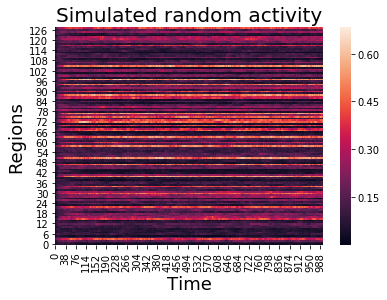

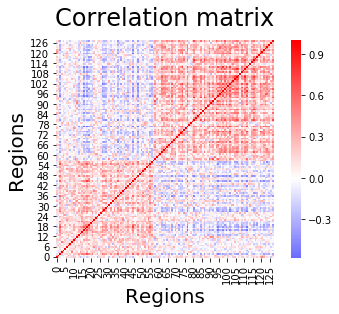

In [313]:
plt.figure()
plt.title('Simulated random activity', fontsize=20)
ax = sns.heatmap(activity.T)
ax.invert_yaxis()
plt.xlabel('Time',fontsize=18)
plt.ylabel('Regions',fontsize=18)

# Construct correlation matrix
corrmat = np.corrcoef(activity.T)
sig = np.multiply(corrmat,corrmat>0)
ci, q = bct.community_louvain(sig)
networkdef = sorted(range(len(ci)), key=lambda k: ci[k])
networkdef = np.asarray(networkdef)
networkdef.shape = (len(networkdef),1)

plt.figure()
ax = sns.heatmap(corrmat[networkdef,networkdef.T],square=True,center=0,cmap='bwr')
ax.invert_yaxis()
plt.title('Correlation matrix',fontsize=24,y=1.04)
plt.xlabel('Regions',fontsize=20)
plt.ylabel('Regions',fontsize=20)
plt.savefig('NoiseInduced_CorrelationMatrix.pdf')

## Analyze recurrent connectivity weights

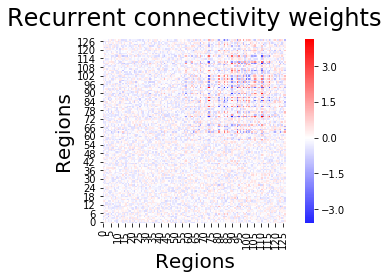

In [314]:
mat = np.asarray(w_rec.data)
plt.figure()
ax = sns.heatmap(mat[networkdef,networkdef.T],square=True,center=0,cmap='bwr')
ax.invert_yaxis()
plt.title('Recurrent connectivity weights',fontsize=24,y=1.04)
plt.xlabel('Regions',fontsize=20)
plt.ylabel('Regions',fontsize=20)
plt.tight_layout()
plt.savefig('GroundTruth_RNN_weights.pdf')

## Do an eigendecomposition on connectivity matrix

In [311]:
eigvalues, eigvec = np.linalg.eig(mat)
ind = sorted(range(len(eigvalues)), key=lambda k: -eigvalues[k])
eigvec = eigvec[ind]
eigvalues = eigvalues[ind]
